# CS5610 M1: Project 1b

## Introduction to Pandas and Seaborn Python Libraries

By Jacob Buysse, 2023-09-07


In this notebook we will demonstrate how to use `pandas` and `seaborn` to load, analyze, plot, clean, and save a file containing real estate transactions in the Sacramento area.

We will be using the `pandas`, `seaborn`, and `matplotlib` libraries imported as `pd`, `sns`, and `plt`, respectively.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt

Configure the default axis label size to 18.  Ensure the plots generated have a high resolution (150dpi).  Also, define a helper function, `wide_figure_size` to generate an axis for a figure size of 14"x3" for wide plots.  NOTE: I couldn't do the following without it displaying an empty plot in the notebook:
```
_, wide_figure_size = plt.pyplot.subplots(figsize=(14, 3))
```
I tried `%%captured` which supporessed it but also suppressed subsequent plots.  I tried `;` and `IPython.utils.io.capture_output()` with no effect.

In [2]:
plt.rc("axes", labelsize=18)
plt.rc("figure", dpi=150)
def wide_figure_size():
    _, ax = plt.pyplot.subplots(figsize=(14, 3))
    return ax

## Load the Data and a First Look

Load the data from the input CSV file and display the head and info.

In [3]:
df = pd.read_csv("csc5610-m2-Sacramento-real-estate-transactions.csv")
df.head()

,address,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


The file contains columns for:
* address
* city
* zip
* state
* beds (number of bedrooms)
* baths (number of bathrooms)
* sq__ft (square footage)
* type
* sale_date
* price
* latitude
* longitude

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


We see that there are 985 rows and that none of the columns contain any nulls.  The Dtype isn't so helpful for `object` columns.


Next, do a deeper analysis on the columns for the underlying python types and also get the count of distinct values to find some candidates for converting to categories.

In [5]:
df.columns.to_series().apply(lambda name: { "type": type(df[name][0]).__name__, "count": df[name].nunique() })

address          {'type': 'str', 'count': 981}
city              {'type': 'str', 'count': 39}
zip             {'type': 'int64', 'count': 68}
state              {'type': 'str', 'count': 1}
beds             {'type': 'int64', 'count': 8}
baths            {'type': 'int64', 'count': 6}
sq__ft         {'type': 'int64', 'count': 603}
type               {'type': 'str', 'count': 4}
sale_date          {'type': 'str', 'count': 5}
price          {'type': 'int64', 'count': 605}
latitude     {'type': 'float64', 'count': 969}
longitude    {'type': 'float64', 'count': 967}
dtype: object

So all of the `object` columns were indeed just `str`s.  `type`, `city`, `state`, and `zip` appear to be good candidates for categories.  `beds`, `baths`, and `sale_date` have low distinct counts but don't logically represent categorical data.  We can also see that sale_date is a `str` but we won't need to parse this data for the analysis being done on this table.

## Type Analysis

Let us take a look at the data for the type column.

In [6]:
df.groupby(by="type").size()

type
Condo            54
Multi-Family     13
Residential     917
Unkown            1
dtype: int64

We can see that `Unknown` is both odd and spelled incorrectly.
We will likely filter that single record out in our final results.
Let us look at some plots for this data.

<Axes: xlabel='Property Type', ylabel='Count'>

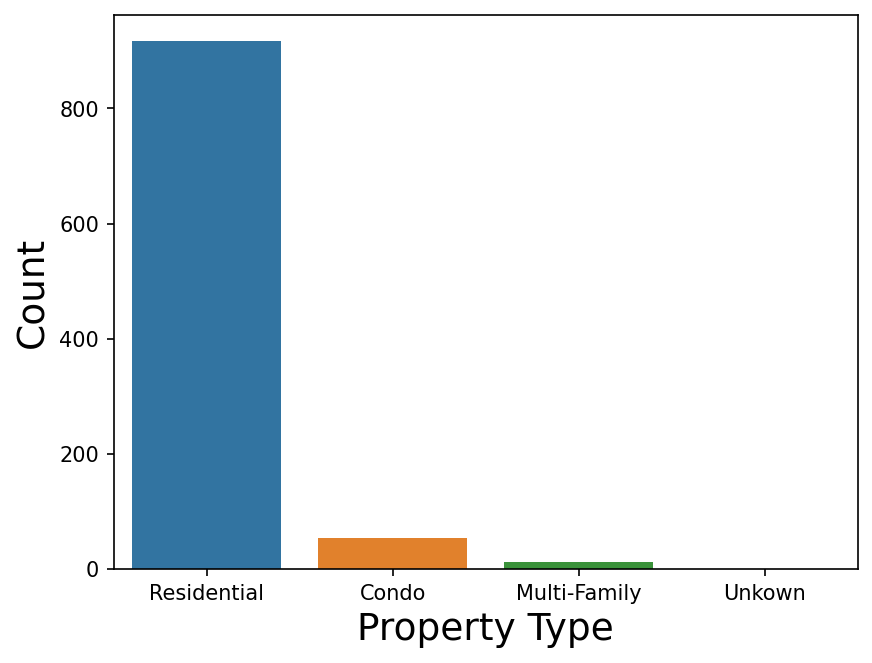

In [7]:
type_plot = sns.countplot(data=df, x="type")
type_plot.set(xlabel="Property Type", ylabel="Count")
type_plot

We can see that condos and multi-family properties don't make up a significant proportion of the rows.  However, I don't think it is enough to exclude the data at this point.

## Zip Analysis

Let us take a look at the histogram plot for the zip codes (even though there are 68 of them, they do make a good candidate for a category).

<Axes: xlabel='Zip Code', ylabel='Count'>

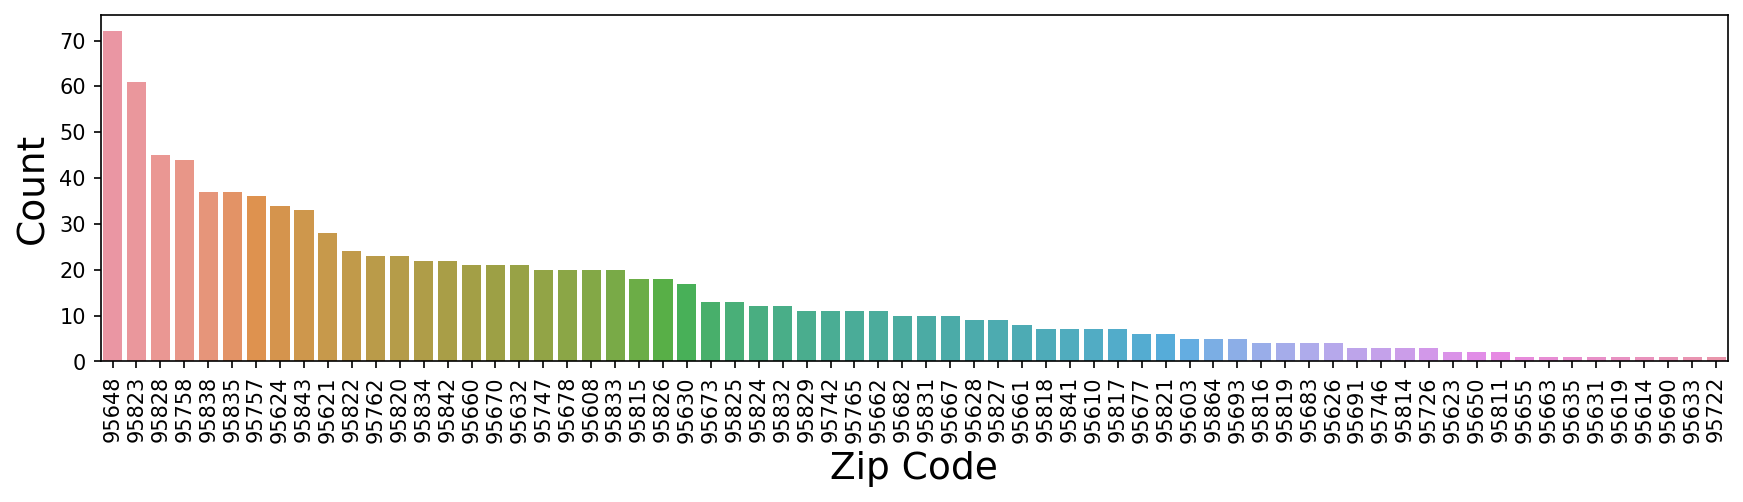

In [8]:
zip_counts = df.zip.value_counts()
zip_plot = sns.countplot(data=df, x="zip", ax=wide_figure_size(), order=zip_counts.index)
zip_plot.set(xlabel="Zip Code", ylabel="Count")
zip_plot.tick_params(axis='x', rotation=90)
zip_plot

None of the zip codes look out of place.  A secondary data source could validate that these zip codes are all valid, but that is out of the scope of this analysis.  However, some of the trailing items appear to have almost no data.

In [9]:
zip_counts.apply(lambda count: "More than 1" if count > 1 else "Exactly 1").value_counts()

count
More than 1    59
Exactly 1       9
Name: count, dtype: int64

And it turns out that 9 of them only have a single corresponding row.  I don't have the exact context for what we will be using this data for, but we will likely want to filter out these records since they don't provide a valid sample size for the given area.

## City Analysis

Let's start by making sure the 39 distinct values in the table don't have any duplicates solely on different casing.

In [10]:
df.city.apply(lambda city: city.lower()).nunique()

39

And we can see that they don't.  Now let us take a look at a histogram plot.

<Axes: xlabel='City', ylabel='Count'>

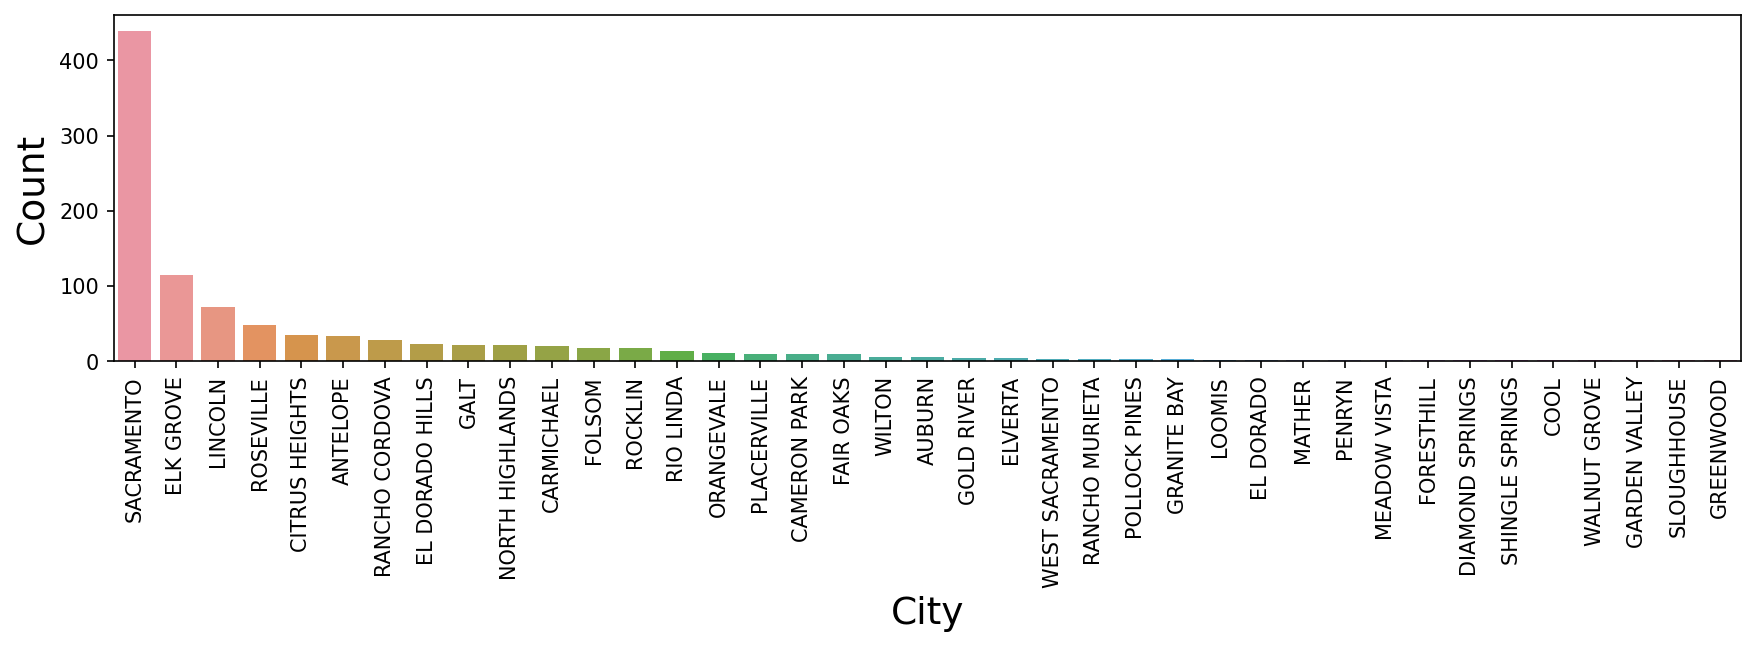

In [11]:
city_counts = df.city.value_counts()
city_plot = sns.countplot(data=df, x="city", ax=wide_figure_size(), order=city_counts.index)
city_plot.set(xlabel="City", ylabel="Count")
city_plot.tick_params(axis='x', rotation=90)
city_plot

The vast majority of rows appear to be for Sacramento proper but there are still 38 other cities being included in the file.  We can also see that some of the data doesn't look valid: Cool.  But upon further investigation it does appear to be a real suburb of Sacramento.  How many of the cities only have one corresponding row in the table?

In [12]:
city_counts.apply(lambda count: "More than 1" if count > 1 else "Exactly 1").value_counts()

count
More than 1    28
Exactly 1      11
Name: count, dtype: int64

We can see that 11 cities only have a single row.  I don't have the exact context for what we will be using this data for, but we will likely want to filter out these records since they don't provide a valid sample size for the given area.

## Beds Analysis

Let describe the beds column to get an idea of the aggregate statistics.

In [13]:
df.beds.describe()

count    985.000000
mean       2.911675
std        1.307932
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: beds, dtype: float64

The min value of 0 looks strange.  How does this look when shown on a histogram plot?

<Axes: xlabel='Number of Bedrooms', ylabel='Count'>

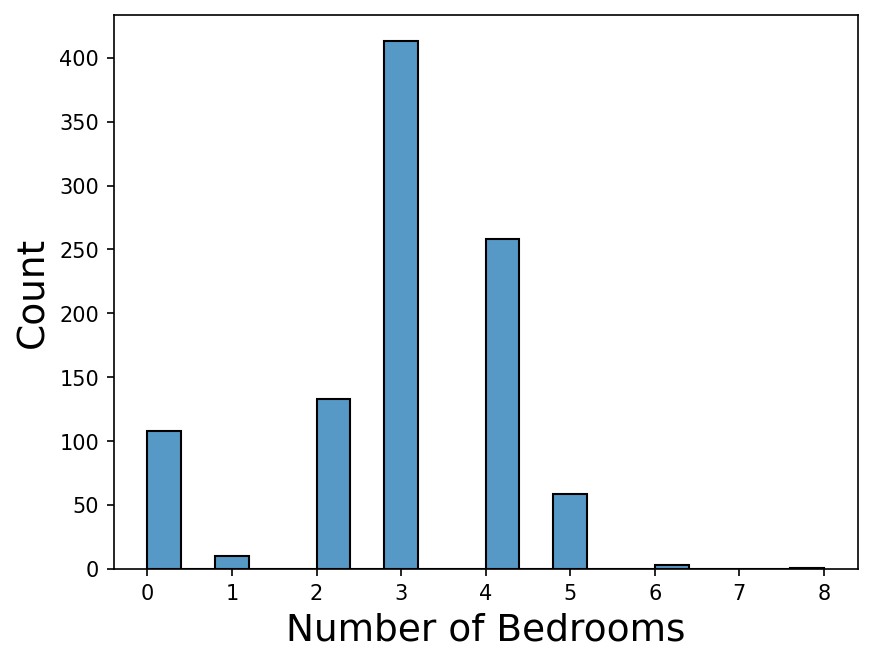

In [14]:
beds_plot = sns.histplot(df.beds)
beds_plot.set(xlabel="Number of Bedrooms")
beds_plot

We have a somewhat normal distribution between 1 and 6.  The zero values are definitely wrong (unless these were studio condos).  There is an outlier out at 8 but that is a reasonable mansion.  It would be worth considering exlucding that house depending on what our final analysis might be.


Let's also look at this on a box plot and violin plot.

<Axes: xlabel='Number of Bedrooms'>

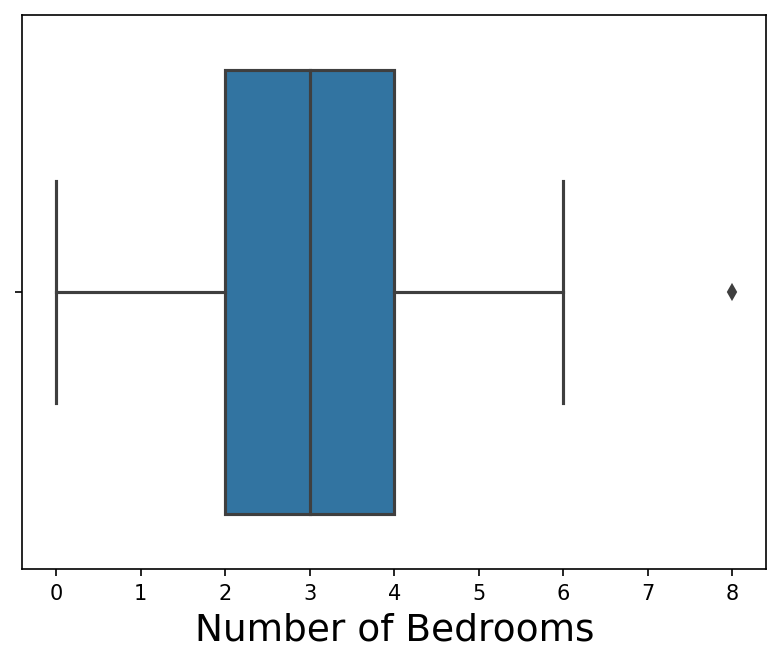

In [15]:
beds_plot = sns.boxplot(x=df.beds)
beds_plot.set(xlabel="Number of Bedrooms")
beds_plot

Here we can see the 8 bedroom house is definitely an outlier and should be filtered out of the final results.

<Axes: xlabel='Number of Bedrooms'>

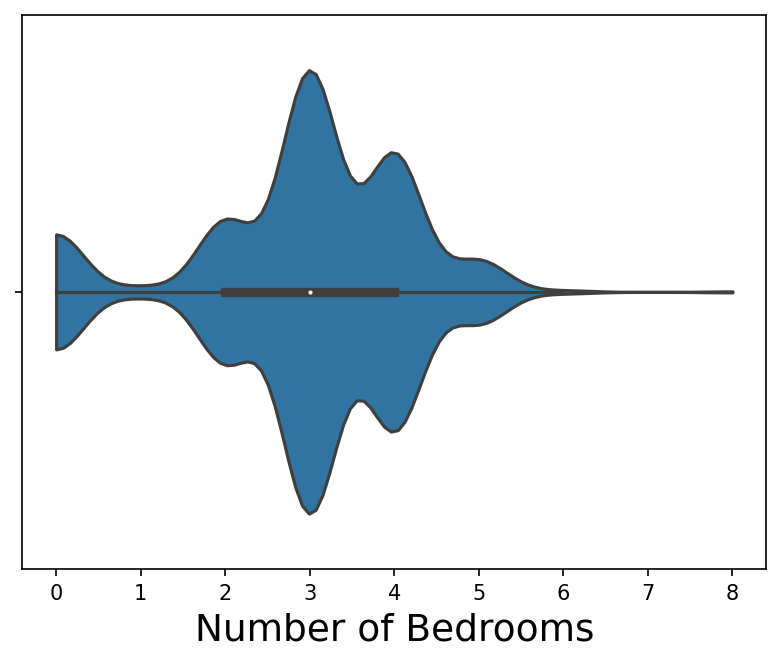

In [16]:
beds_plot = sns.violinplot(x=df.beds, cut=0)
beds_plot.set(xlabel="Number of Bedrooms")
beds_plot

The violin plot doesn't tell us anything new.  It does look very wavy, for whatever that is worth.

Let us do another aggregate analysis on the table but with the bad data and outliers excluded.

In [17]:
df.beds[lambda beds: (beds > 0) & (beds < 8)].describe()

count    876.000000
mean       3.264840
std        0.850248
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        6.000000
Name: beds, dtype: float64

We can see that the mean and standard deviation are now more reasonable, 3.2 ± 0.9, and a range of 1 to 6.

## Baths Analysis

TODO: Left off here.

In [18]:
df.baths.describe()

count    985.000000
mean       1.776650
std        0.895371
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: baths, dtype: float64

<Axes: xlabel='Number of Bathrooms', ylabel='Count'>

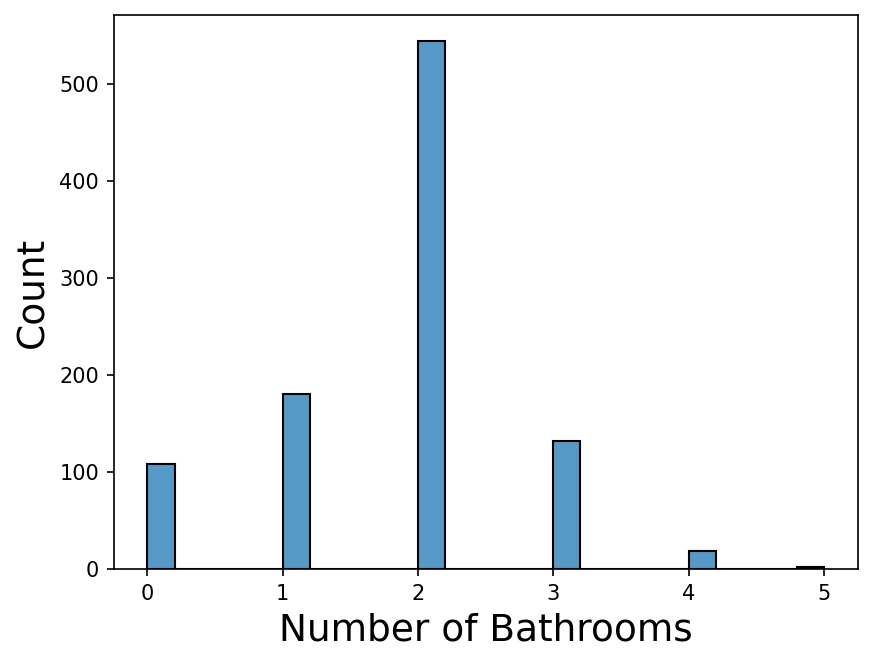

In [19]:
baths_plot = sns.histplot(df.baths)
baths_plot.set(xlabel="Number of Bathrooms")
baths_plot

<Axes: xlabel='Number of Bathrooms'>

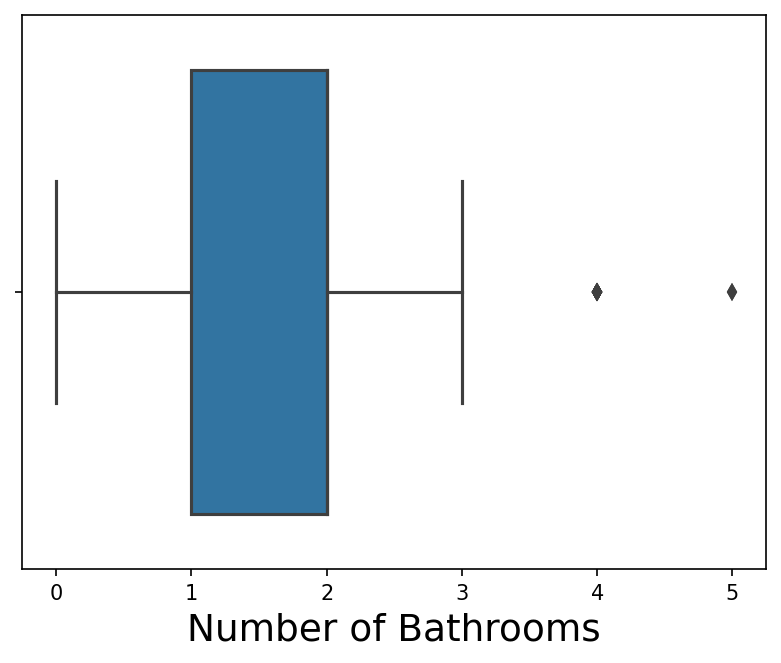

In [20]:
baths_plot = sns.boxplot(x=df.baths)
baths_plot.set(xlabel="Number of Bathrooms")
baths_plot

<Axes: xlabel='Number of Bathrooms'>

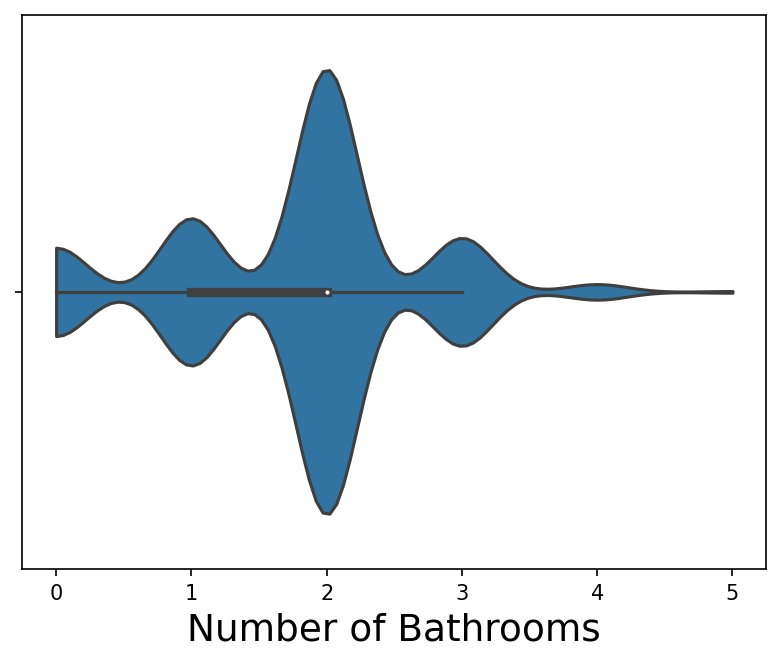

In [21]:
baths_plot = sns.violinplot(x=df.baths, cut=0)
baths_plot.set(xlabel="Number of Bathrooms")
baths_plot

In [22]:
df.baths[lambda baths: baths > 0].describe()

count    877.000000
mean       1.995439
std        0.680771
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: baths, dtype: float64

In [23]:
df.sq__ft.describe()

count     985.000000
mean     1314.916751
std       853.048243
min         0.000000
25%       952.000000
50%      1304.000000
75%      1718.000000
max      5822.000000
Name: sq__ft, dtype: float64

<Axes: xlabel='Square Footage', ylabel='Count'>

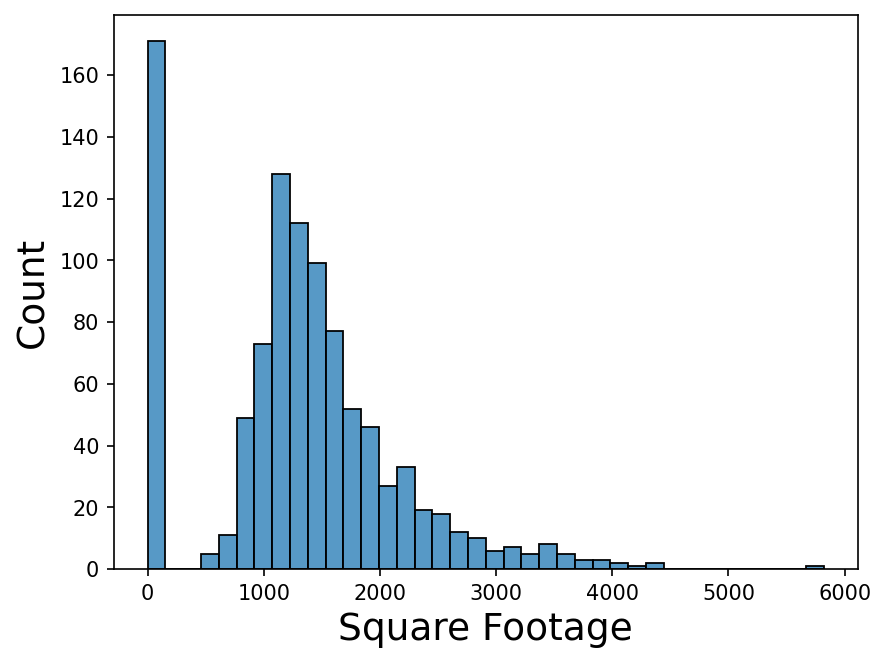

In [24]:
sq_ft_plot = sns.histplot(df.sq__ft)
sq_ft_plot.set(xlabel="Square Footage")
sq_ft_plot

<Axes: xlabel='Square Footage'>

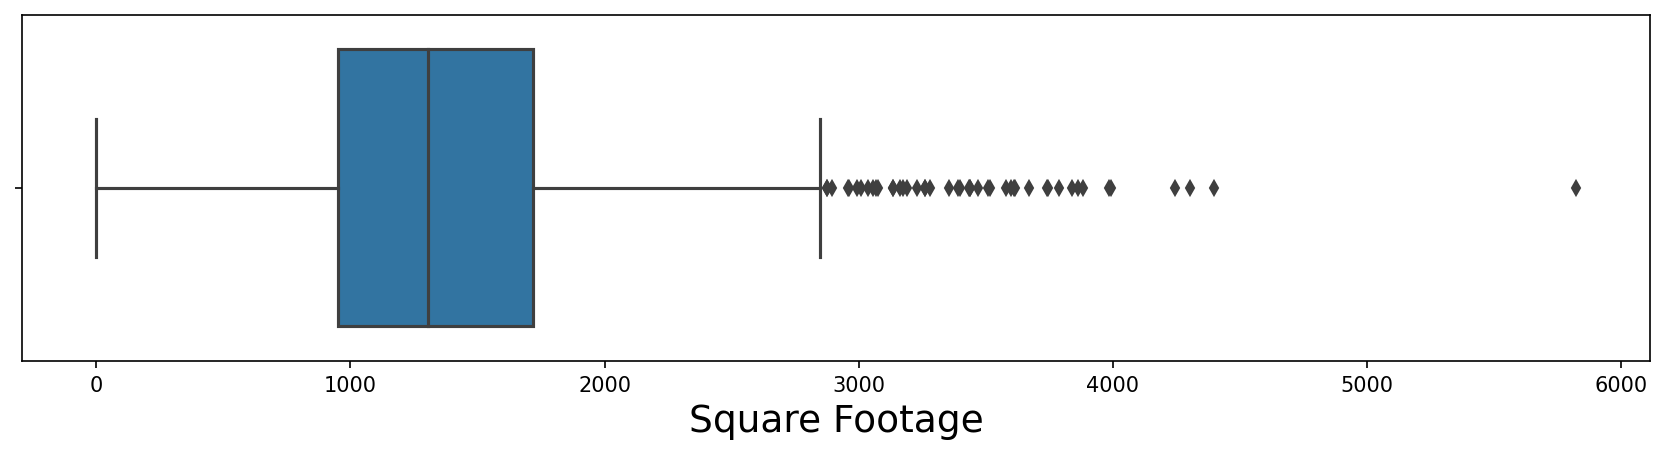

In [25]:
sq_ft_plot = sns.boxplot(x=df.sq__ft, ax=wide_figure_size())
sq_ft_plot.set(xlabel="Square Footage")
sq_ft_plot

<Axes: xlabel='Square Footage'>

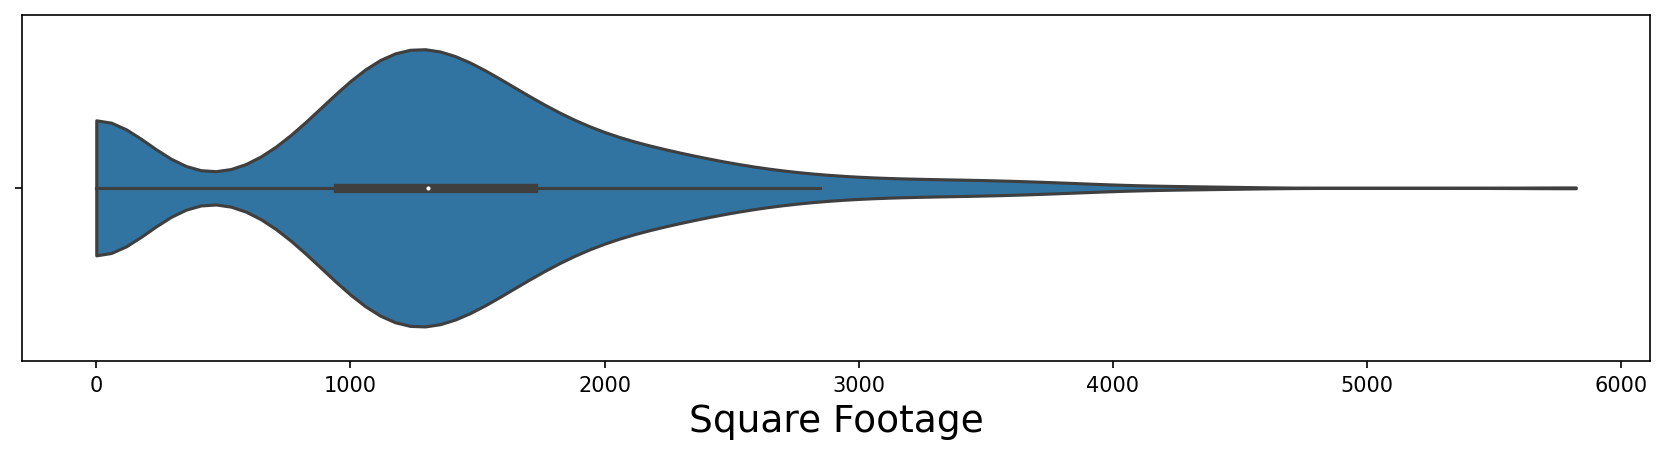

In [26]:
sq_ft_plot = sns.violinplot(x=df.sq__ft, ax=wide_figure_size(), cut=0)
sq_ft_plot.set(xlabel="Square Footage")
sq_ft_plot

In [27]:
filtered_sq_ft = df.sq__ft[lambda sq__ft: (sq__ft > 0) & (sq__ft < 5000)]
filtered_sq_ft.describe()

count     813.000000
mean     1585.942189
std       647.423526
min       484.000000
25%      1144.000000
50%      1418.000000
75%      1851.000000
max      4400.000000
Name: sq__ft, dtype: float64

In [28]:
filtered_sq_ft.sort_values().head(10)

336    484
292    539
18     588
168    610
868    611
338    623
354    625
881    682
371    696
171    722
Name: sq__ft, dtype: int64

In [29]:
filtered_sq_ft.sort_values().tail(10)

307    3746
552    3788
330    3838
855    3863
319    3881
328    3984
317    3992
535    4246
534    4303
864    4400
Name: sq__ft, dtype: int64

In [30]:
df.price.describe()

count       985.000000
mean     234144.263959
std      138365.839085
min        1551.000000
25%      145000.000000
50%      213750.000000
75%      300000.000000
max      884790.000000
Name: price, dtype: float64

<Axes: xlabel='Price (USD)', ylabel='Count'>

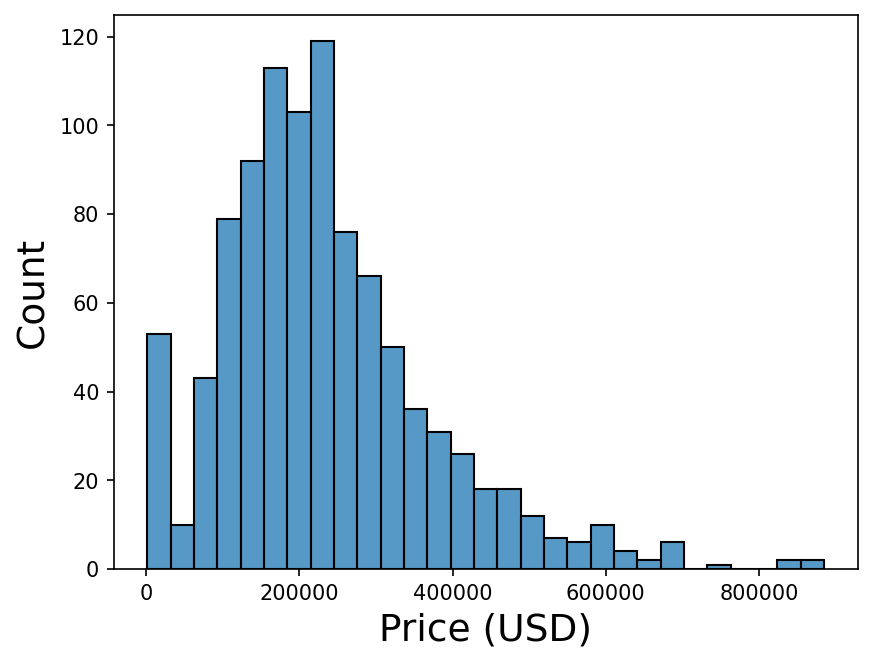

In [31]:
price_plot = sns.histplot(df.price)
price_plot.set(xlabel="Price (USD)")
price_plot

<Axes: xlabel='Price (USD)'>

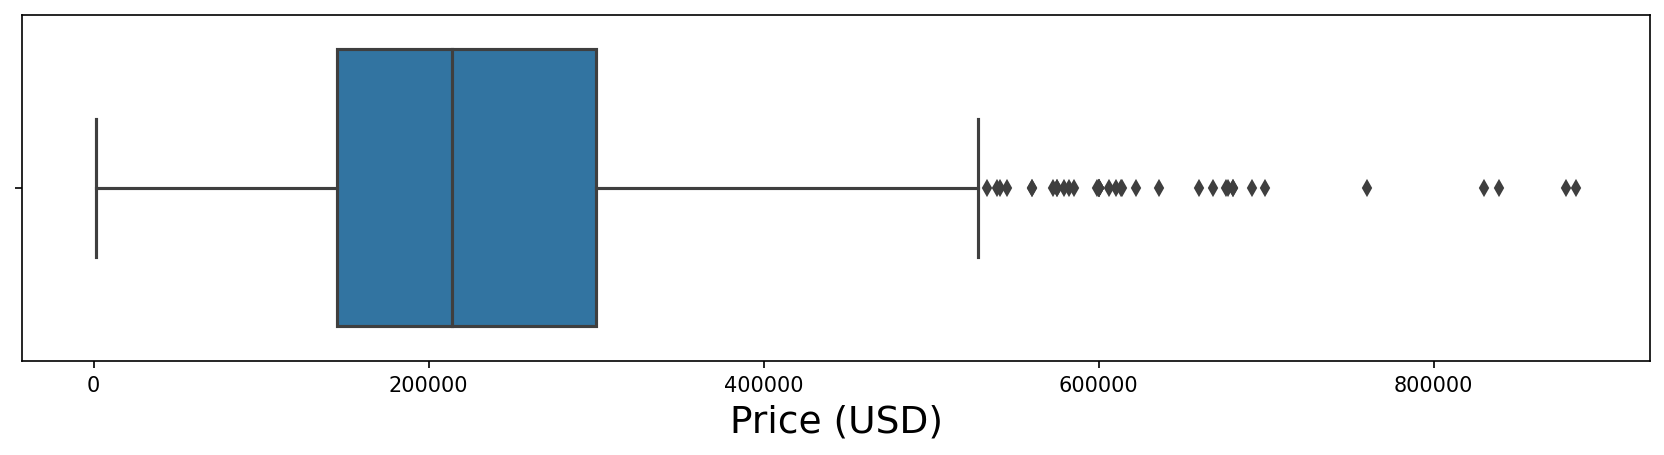

In [32]:
price_plot = sns.boxplot(x=df.price, ax=wide_figure_size())
price_plot.set(xlabel="Price (USD)")
price_plot

<Axes: xlabel='Price (USD)'>

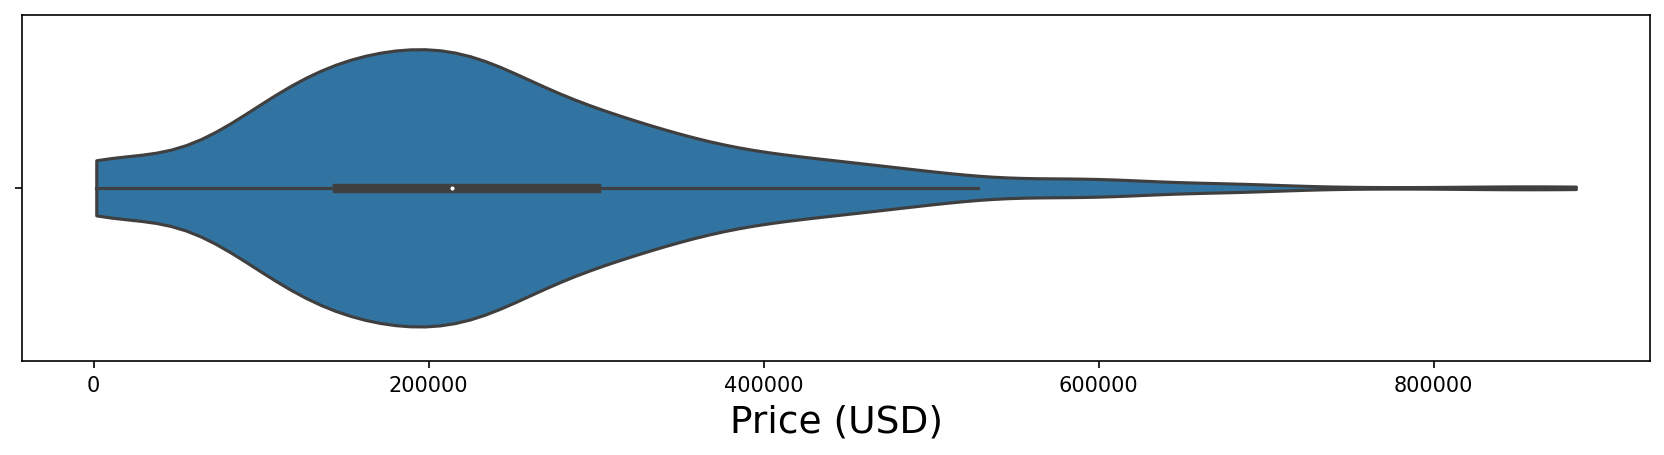

In [33]:
price_plot = sns.violinplot(x=df.price, ax=wide_figure_size(), cut=0)
price_plot.set(xlabel="Price (USD)")
price_plot

In [34]:
df.price.sort_values().head(10)

865    1551
866    2000
580    4897
584    4897
585    4897
586    4897
587    4897
588    4897
589    4897
590    4897
Name: price, dtype: int64

In [35]:
df.price.sort_values().tail(10)

551    677048
862    680000
332    680000
552    691659
333    699000
553    760000
157    830000
334    839000
863    879000
864    884790
Name: price, dtype: int64

In [36]:
df.price[lambda price: price > 5000].describe()

count       934.000000
mean     246668.732334
std      130991.448400
min       30000.000000
25%      156000.000000
50%      220000.000000
75%      305000.000000
max      884790.000000
Name: price, dtype: float64

In [37]:
df.price[lambda price: (price > 5000) & (price < 800_000)].describe()

count       930.000000
mean     244038.501075
std      124952.156754
min       30000.000000
25%      156000.000000
50%      220000.000000
75%      303750.000000
max      760000.000000
Name: price, dtype: float64

In [38]:
df.latitude.describe()

count    985.000000
mean      38.607732
std        0.145433
min       38.241514
25%       38.482717
50%       38.626582
75%       38.695589
max       39.020808
Name: latitude, dtype: float64

In [39]:
df.latitude.sort_values().head(10)

174    38.241514
372    38.242270
820    38.247659
63     38.251808
508    38.253500
761    38.258976
957    38.259708
61     38.260443
409    38.260467
189    38.270617
Name: latitude, dtype: float64

In [40]:
df.latitude.sort_values().tail(10)

976    38.897814
750    38.899180
828    38.904869
778    38.905927
468    38.931671
833    38.935579
484    38.939802
142    38.945357
242    39.008159
686    39.020808
Name: latitude, dtype: float64

<Axes: xlabel='Latitude'>

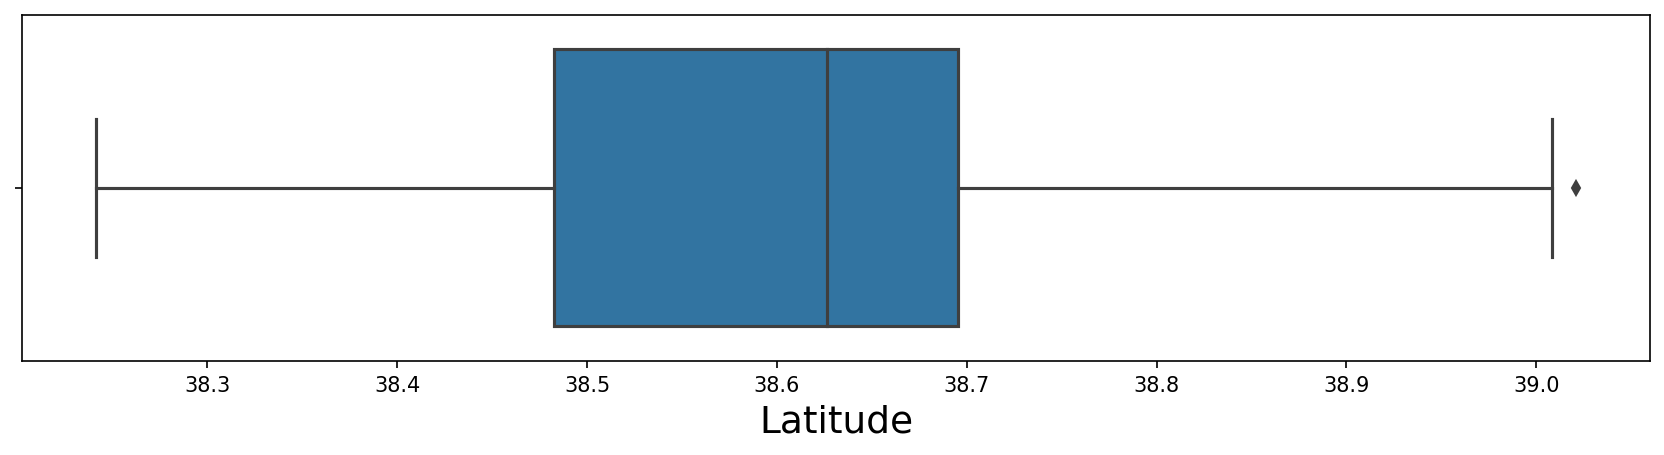

In [41]:
lat_plot = sns.boxplot(x=df.latitude, ax=wide_figure_size())
lat_plot.set(xlabel="Latitude")
lat_plot

<Axes: xlabel='Latitude'>

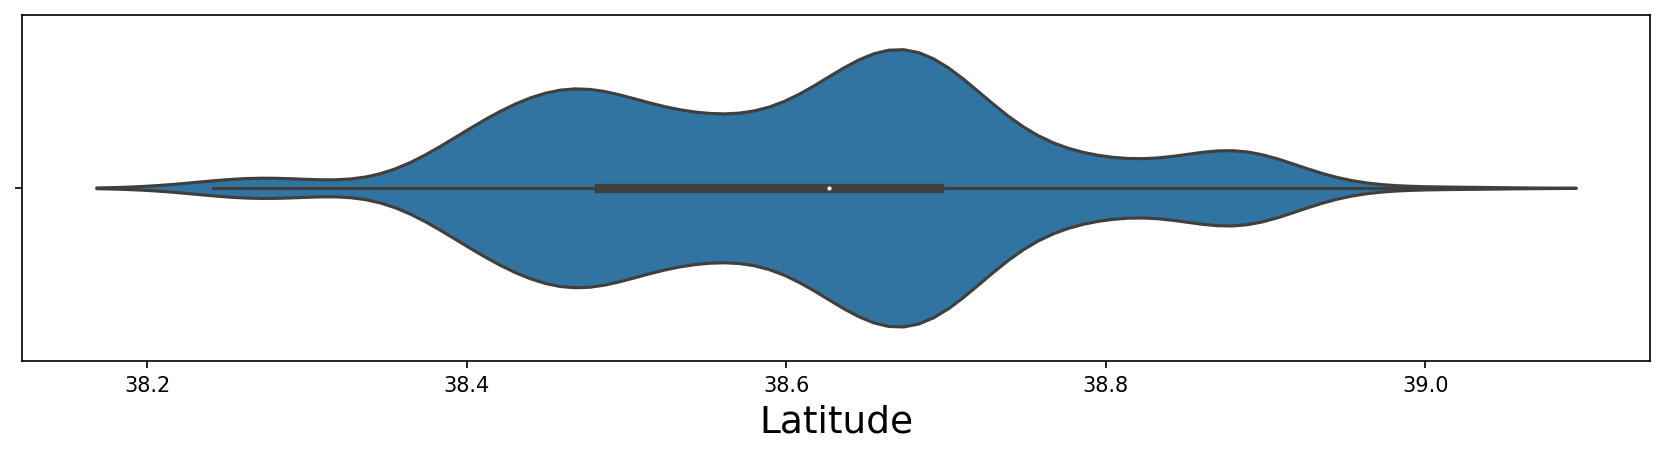

In [42]:
lat_plot = sns.violinplot(x=df.latitude, ax=wide_figure_size())
lat_plot.set(xlabel="Latitude")
lat_plot

In [43]:
df.longitude.describe()

count    985.000000
mean    -121.355982
std        0.138278
min     -121.551704
25%     -121.446127
50%     -121.376220
75%     -121.295778
max     -120.597599
Name: longitude, dtype: float64

In [44]:
df.longitude.sort_values().head(10)

310   -121.551704
445   -121.550527
117   -121.549521
318   -121.549437
446   -121.549049
787   -121.547664
98    -121.547572
144   -121.545947
286   -121.545490
101   -121.544023
Name: longitude, dtype: float64

In [45]:
df.longitude.sort_values().tail(10)

709   -120.810235
754   -120.809254
771   -120.802458
227   -120.794254
297   -120.784145
518   -120.748039
844   -120.693641
106   -120.604760
102   -120.603872
663   -120.597599
Name: longitude, dtype: float64

<Axes: xlabel='Longitude'>

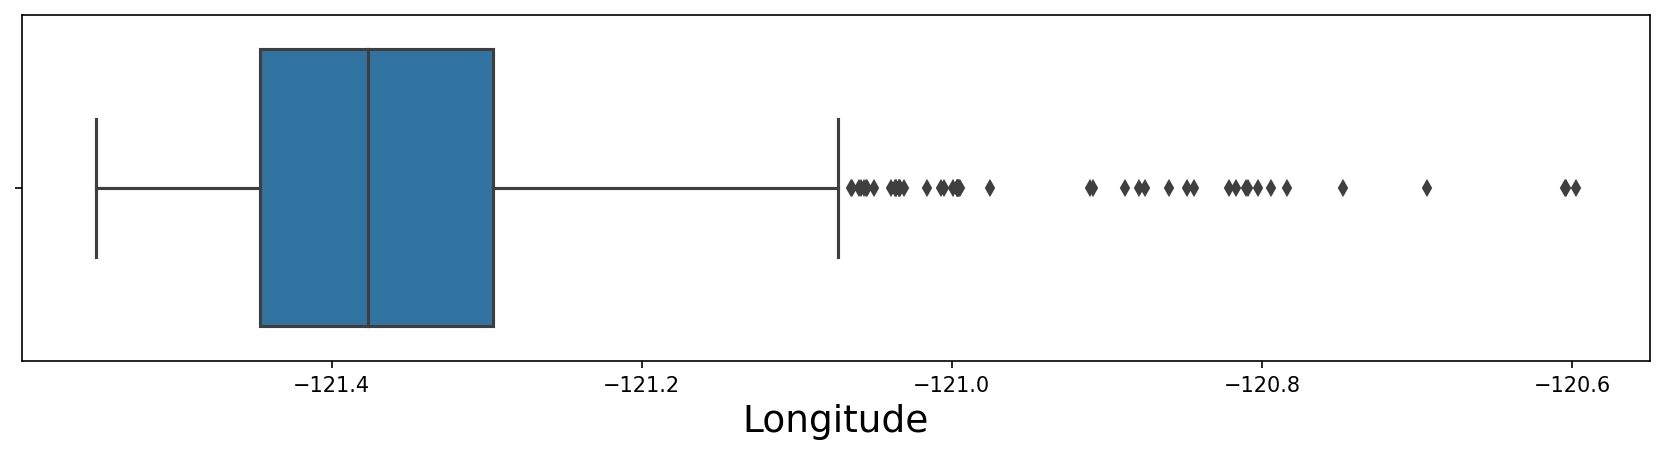

In [46]:
long_plot = sns.boxplot(x=df.longitude, ax=wide_figure_size())
long_plot.set(xlabel="Longitude")
long_plot

<Axes: xlabel='Longitude'>

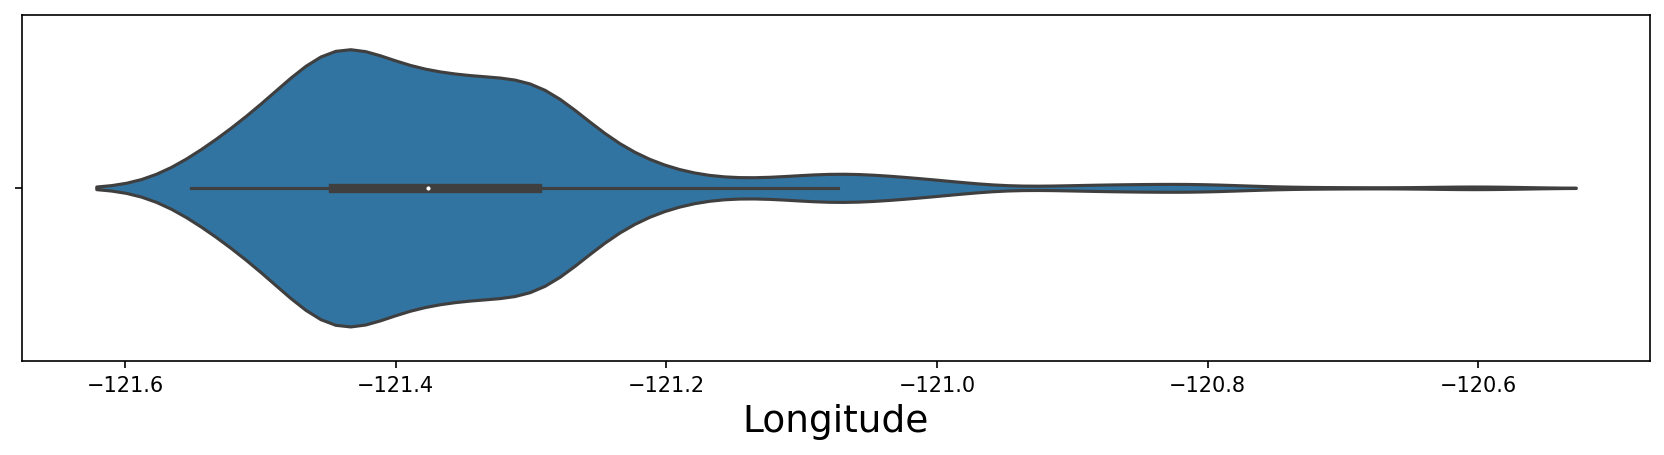

In [47]:
long_plot = sns.violinplot(x=df.longitude, ax=wide_figure_size())
long_plot.set(xlabel="Longitude")
long_plot

<Axes: xlabel='Longitude', ylabel='Latitude'>

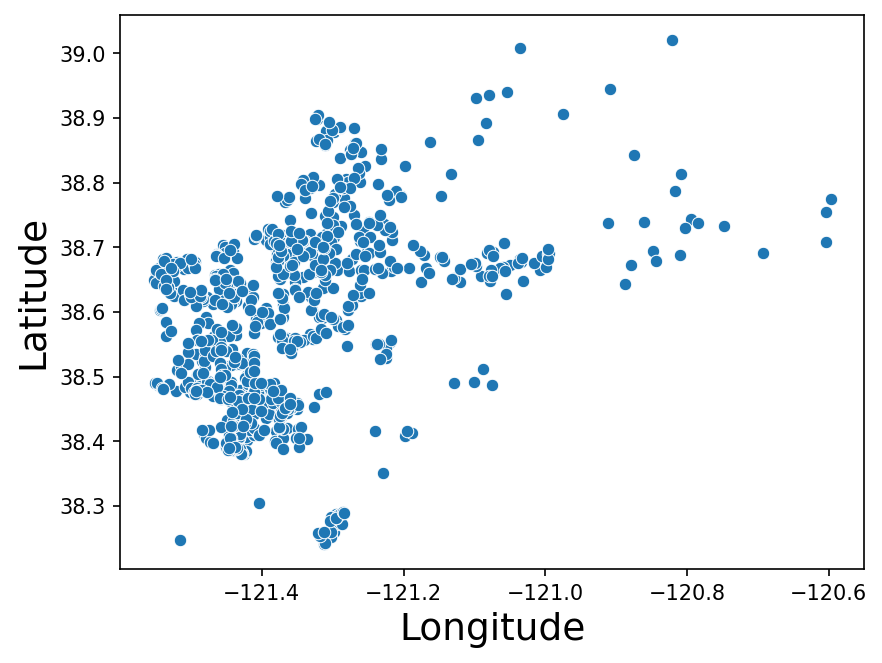

In [48]:
lat_long_plot = sns.scatterplot(data=df, x="longitude", y="latitude")
lat_long_plot.set(xlabel="Longitude", ylabel="Latitude")
lat_long_plot

TODO: Just a reminder that KDE stands for kernel density estimate.

<Axes: xlabel='Longitude', ylabel='Latitude'>

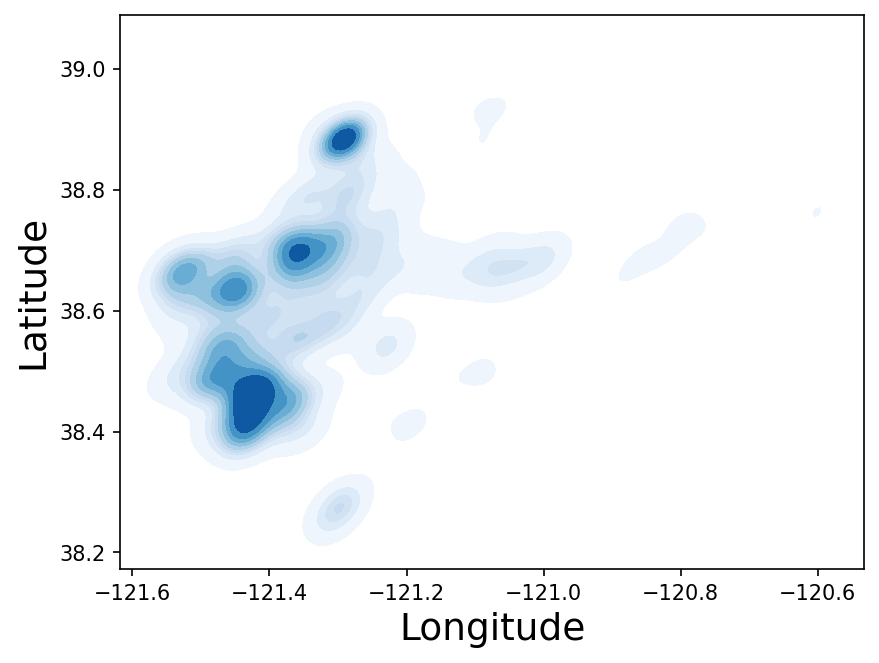

In [49]:
lat_long_plot = sns.kdeplot(x=df.longitude, y=df.latitude, cmap="Blues", fill=True, bw_adjust=0.5)
lat_long_plot.set(xlabel="Longitude", ylabel="Latitude")
lat_long_plot

In [50]:
price_per_sq_ft = df.price / df.sq__ft
price_per_sq_ft.describe()

count    985.000000
mean            inf
std             NaN
min        0.343525
25%      114.142628
50%      149.253731
75%      213.178295
max             inf
dtype: float64

In [51]:
filtered_price_per_sq_ft = price_per_sq_ft[lambda value: (value > 1) & (value < 1_000)]
filtered_price_per_sq_ft.describe()

count    813.000000
mean     145.852010
std       54.636882
min       25.728988
25%      109.176748
50%      137.152778
75%      170.438670
max      619.666048
dtype: float64

<Axes: xlabel='Price (USD) per Square Foot', ylabel='Count'>

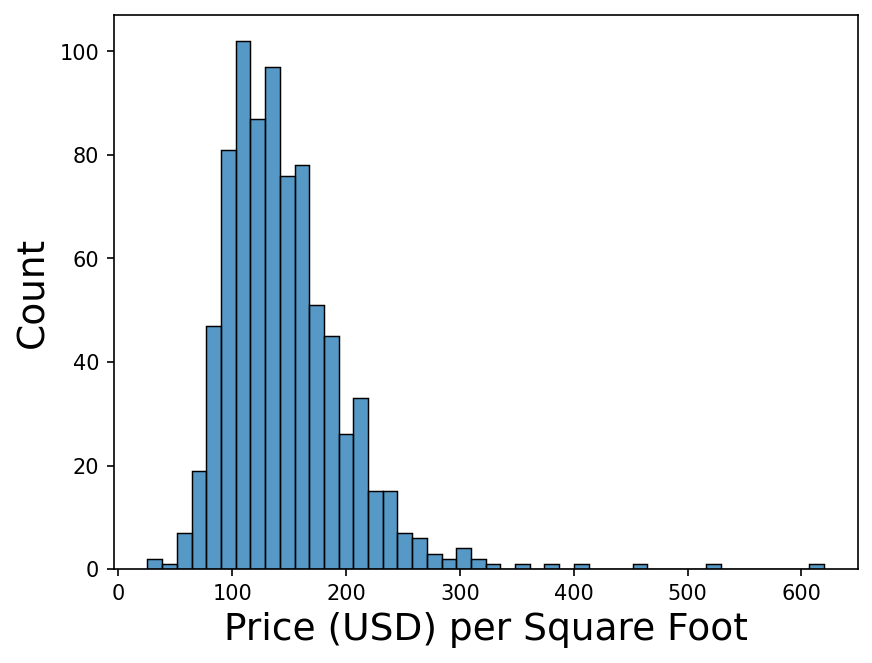

In [52]:
per_sq_ft_plot = sns.histplot(filtered_price_per_sq_ft)
per_sq_ft_plot.set(xlabel="Price (USD) per Square Foot")
per_sq_ft_plot

<Axes: xlabel='Price (USD) per Square Foot'>

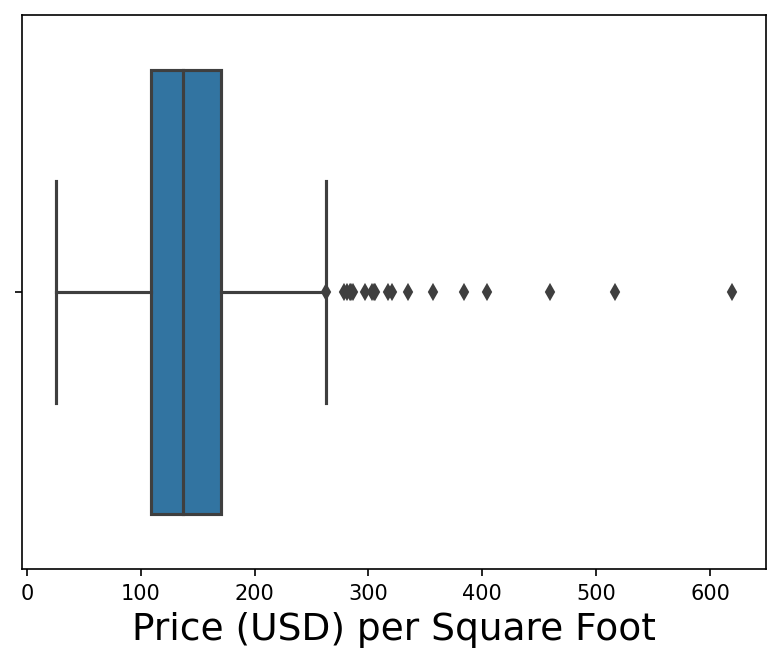

In [53]:
per_sq_ft_plot = sns.boxplot(x=filtered_price_per_sq_ft)
per_sq_ft_plot.set(xlabel="Price (USD) per Square Foot")
per_sq_ft_plot

<Axes: xlabel='Price (USD) per Square Foot'>

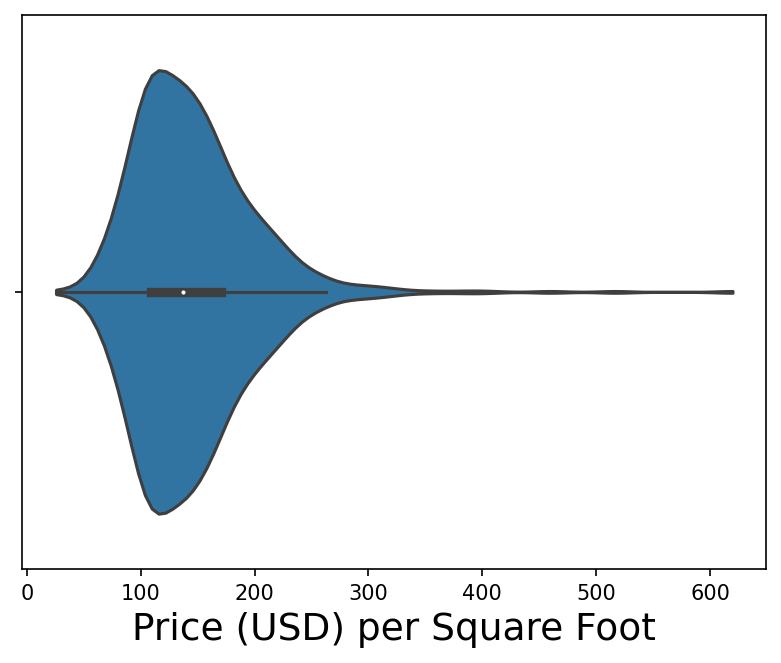

In [54]:
per_sq_ft_plot = sns.violinplot(x=filtered_price_per_sq_ft, cut=0)
per_sq_ft_plot.set(xlabel="Price (USD) per Square Foot")
per_sq_ft_plot

## Cleaning and Saving

Now that we have finished our analysis of all of the columns in the table we can finally filter out the data we don't want and then convert our columns over to categories.  Note that I am doing the category conversion after the filtering so the filtered out values don't show up as categories.

In [55]:
clean_df = df\
    .merge(zip_counts.rename("zip_count"), left_on="zip", right_index=True)\
    .merge(city_counts.rename("city_count"), left_on="city", right_index=True)\
    .merge(price_per_sq_ft.rename("price_per_sq_ft"), left_index=True, right_index=True)\
    [lambda row:
        (row.type != "Unkown") & # Ignore a listing with type Unkown (both a typo and indicates we don't know the type)
        (row.zip_count > 1) & # Ignore a listing if it is the only one in a zip code
        (row.city_count > 1) & # Ignore a listing if it is the only one in a city
        (row.beds > 0) & # Ignore listings with no beds
        (row.beds < 8) & # Ignore the outlier with 8 beds
        (row.baths > 0) & # Ignore listings with no baths
        (row.sq__ft > 0) & # Ignore listings missing the square footage
        (row.sq__ft < 5000) & # Ignore listings over 5k sq. ft. (only one listing)
        (row.price >= 5000) & # Ignore listings below $5k (unreasonable price)
        (row.price_per_sq_ft > 1) & # Ignore prices per sq. ft. below $1
        (row.price_per_sq_ft < 300) # Ignore prices per sq. ft. over $300 (not enough samples)
    ]\
    [df.columns]\
    .reset_index()\
    .copy()
clean_df.city = clean_df.city.apply(lambda name: name.upper()).astype("category")
clean_df.zip = clean_df.zip.apply(lambda zip: f"{zip:05d}").astype("category")
clean_df.state = clean_df.state.astype("category")
clean_df.type = clean_df.type.astype("category")
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   index      794 non-null    int64   
 1   address    794 non-null    object  
 2   city       794 non-null    category
 3   zip        794 non-null    category
 4   state      794 non-null    category
 5   beds       794 non-null    int64   
 6   baths      794 non-null    int64   
 7   sq__ft     794 non-null    int64   
 8   type       794 non-null    category
 9   sale_date  794 non-null    object  
 10  price      794 non-null    int64   
 11  latitude   794 non-null    float64 
 12  longitude  794 non-null    float64 
dtypes: category(4), float64(2), int64(5), object(2)
memory usage: 63.1+ KB


We can see that our four columns are now category dtypes.  Our final row count after all of our filters is 794 out of the original 985 (191 records being exclude for bad data, sample size too small, or outside reasonable ranges).  This might have been a bit aggressive, but again, without knowing the final application of this data it is hard to tell.

Let us finally save the cleaned table back to a feather file.

In [56]:
clean_df.to_feather("csc5610-m2-Sacramento-real-estate-transactions-cleaned.feather")